In [66]:
# load libraries

import glob
import os
import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
# let's have a look at the files

path = r'C:\Users\sonja tilly.ABERDEEN\text_docs\*'

files = glob.glob(path)

files[0:10]

['C:\\Users\\sonja tilly.ABERDEEN\\text_docs\\Aberdeen.txt',
 'C:\\Users\\sonja tilly.ABERDEEN\\text_docs\\Alliance Bernstein.txt',
 'C:\\Users\\sonja tilly.ABERDEEN\\text_docs\\Allianz.txt',
 'C:\\Users\\sonja tilly.ABERDEEN\\text_docs\\Amundi.txt',
 'C:\\Users\\sonja tilly.ABERDEEN\\text_docs\\Aviva.txt',
 'C:\\Users\\sonja tilly.ABERDEEN\\text_docs\\AXA.txt',
 'C:\\Users\\sonja tilly.ABERDEEN\\text_docs\\Barclays.txt',
 'C:\\Users\\sonja tilly.ABERDEEN\\text_docs\\BlackRock.txt',
 'C:\\Users\\sonja tilly.ABERDEEN\\text_docs\\BlueBay.txt',
 'C:\\Users\\sonja tilly.ABERDEEN\\text_docs\\BNP Paribas.txt']

In [68]:
# let's read in the files and append to a list of lists

list_of_lists = []

for file in files:
    text_file = open(file)
    lines = text_file.readlines()
    list_of_lists.append(lines)
    text_file.close()

In [69]:
list_of_lists[0][:5]

['Aberdeen\n',
 'Economic Outlook – January 2018\n',
 'Monthly highlights: Global economic strength to continue in 2018\n',
 'The global economy showed no sign of losing any momentum\n',
 'in 2017 Q4 and is heading into 2018 in a healthy state. We have\n']

In [70]:
# extract list of file company names

list_of_names = []

for f in files:
    head, tail = os.path.split(f)
    name = os.path.splitext(os.path.basename(tail))[0]
    list_of_names.append(name)
    
print('Number of documents:', len(list_of_names))
print(' ')
print(list_of_names)

Number of documents: 61
 
['Aberdeen', 'Alliance Bernstein', 'Allianz', 'Amundi', 'Aviva', 'AXA', 'Barclays', 'BlackRock', 'BlueBay', 'BNP Paribas', 'Candriam', 'Capital Economics', 'Citi', 'ClearBridge', 'Credit Suisse', 'Danske Bank', 'Deutsche Bank', 'Eastspring', 'Fidelity', 'Fisher Investments', 'Franklin Templeton', 'GAM', 'Goldman Sachs', 'Hermes', 'HSBC', 'ING', 'Invesco', 'Investec', 'JanusHenderson', 'JOHCM', 'JPM', 'Kames Capital', 'Legg Mason', 'Liontrust', 'Lloyds Bank', 'Loomis Sayles', 'Macquarie', 'MAN GLG', 'MandG', 'Mirabaud', 'Morgan Stanley', 'Muzinich', 'Neptune', 'Neuberger Berman', 'Nordea', 'Pictet', 'Pimco', 'RLAM', 'Robeco', 'Sanlam', 'Schroders', 'SEB', 'Smith&Williamson', 'Standard Life', 'T Rowe Price', 'Threadneedle', 'UBP', 'UBS', 'Unicredit', 'Vanguard', 'Wellington']


In [140]:
# load nltk's English stopwords as 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
more_stopwords = ['and', 'to', 'the', 'we', 'of', 'in', 'are', 'on', 'stephan',
                 'year', 'investment', 'investor', 'portfolio', 'analyst', 'q',
                 'manager', 'outlook', 'fund', 'economy', 'market', 'bank']
stopwords.extend(more_stopwords)
print(stopwords[0:10])

# create tokenizer that picks out sequences of alphanumeric characters as tokens and drops everything else
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

from nltk import pos_tag

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [141]:
# tidy up list of lists

def tidy_up(temp0):
    temp1 = [[t.lower() for t in l] for l in temp0]
    temp2 = [[t.replace('\n','') for t in l] for l in temp1]
    temp3 = [[t.replace('\r','') for t in l] for l in temp2]
    temp4 = [[pos_tag(tokenizer.tokenize(t)) for t in l] for l in temp3]
    return temp4

In [142]:
# create function to create list of sentences

def raw_text(lol):
    temp = []
    for i in lol:
        sent = " ".join(str(item) for item in i)
        temp.append(sent)
    return temp

In [143]:
tokens = tidy_up(list_of_lists)

tokens[0][1]

[('economic', 'JJ'), ('outlook', 'NN'), ('january', 'NN'), ('2018', 'CD')]

In [144]:
# extract nouns

from nltk import pos_tag

nouns = []

for t in tokens:
    tmp = []
    for l in t:
        for token, pos in l:
            if pos.startswith('N'):
                tmp.append(token)
            
    nouns.append(tmp) 



In [145]:
nouns[0][0:10]

['aberdeen',
 'outlook',
 'january',
 'highlights',
 'strength',
 'economy',
 'sign',
 'momentum',
 'q4',
 'state']

In [146]:
# load nltk's Lemmatizer

from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()    

In [147]:
# lemmatize tokens

lems = []

for lst in nouns:
    temp = []
    for l in lst:
        st = wordnet_lemmatizer.lemmatize(l)
        temp.append(st)
    lems.append(temp) 

In [148]:
lems[0][0:10]

['aberdeen',
 'outlook',
 'january',
 'highlight',
 'strength',
 'economy',
 'sign',
 'momentum',
 'q4',
 'state']

In [149]:
lems_sent = raw_text(lems)


In [150]:
# remove stopwords from stems

clean_lems = [[i for i in l.split() if i not in stopwords] for l in lems_sent]
clean_lems[0][0:10]


['aberdeen',
 'january',
 'highlight',
 'strength',
 'sign',
 'momentum',
 'q4',
 'state',
 'forecast',
 'growth']

In [151]:
corpus = raw_text(clean_lems)
corpus[0][0:200]

'aberdeen january highlight strength sign momentum q4 state forecast growth percentage point purchasing index pmi level month trade prospect commodity price manufacturer commodity producer growth whole'

In [152]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# try Word Frequencies with TfidfVectorizer

# list text

def tfidf_vectorizer(text):
          
    # create the transform
    vectorizer = TfidfVectorizer()    
        
    # fit and encode text
    vector = vectorizer.fit_transform(text)

    # summarize encoded vector
    #print(vector.shape)
    array = vector.toarray()
        
    return array

In [153]:
text_array = tfidf_vectorizer(corpus)

In [154]:
# reduce data to 2 dimensions

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

red = pca.fit_transform(text_array)

red_df = pd.DataFrame(red, columns=['X','Y'])


In [155]:
pca.explained_variance_

array([ 0.04303423,  0.03660087])

In [156]:
# set up kmeans algorithm

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

def clusterKMeans(k):
    clusterer = KMeans(n_clusters=k, random_state=47).fit(red_df)
    centroids = clusterer.cluster_centers_
    labels = clusterer.labels_
    score = silhouette_score(red_df, clusterer.labels_, metric='euclidean')
    samples_score = silhouette_samples(red_df, clusterer.labels_, metric='euclidean')
    return centroids, labels, score, samples_score

for i in range(2,8):
    centroids, labels, score, samples_score = clusterKMeans(i)
    print("The silhouette score for "+ str(i) + " clusters is: {:.3}.".format(score))

The silhouette score for 2 clusters is: 0.37.
The silhouette score for 3 clusters is: 0.411.
The silhouette score for 4 clusters is: 0.389.
The silhouette score for 5 clusters is: 0.396.
The silhouette score for 6 clusters is: 0.385.
The silhouette score for 7 clusters is: 0.419.


In [157]:
# edit number of clusters

for i in range(7,8):
    centroids, labels, score, samples_score = clusterKMeans(i)
    
red_df['Cluster'] = labels

red_df["Names"] = list_of_names

red_df.head()


,X,Y,Cluster,Names
0,-0.196484,0.308973,6,Aberdeen
1,-0.343523,0.168530,6,Alliance Bernstein
2,0.027285,-0.111950,3,Allianz
3,-0.224798,-0.098185,2,Amundi
4,-0.068110,0.101894,3,Aviva


In [158]:
#add centroid coordinates for each cluster

centroidsx = {0:centroids[0:1,0], 1:centroids[1:2, 0], 2:centroids[2:3, 0], 3:centroids[3:4, 0],
             4:centroids[4:5, 0], 5:centroids[5:6, 0], 6:centroids[6:7, 0]}

centroidsy = {0:centroids[0:1,1], 1:centroids[1:2, 1], 2:centroids[2:3, 1], 3:centroids[3:4, 1],
             4:centroids[4:5, 1], 5:centroids[5:6, 1], 6:centroids[6:7, 1]}

red_df['Centroidx'] = red_df['Cluster'].map(centroidsx)

red_df['Centroidy'] = red_df['Cluster'].map(centroidsy)

red_df.tail()


,X,Y,Cluster,Names,Centroidx,Centroidy
56,0.086075,0.126187,4,UBP,[0.108410479476],[0.228439288427]
57,0.110754,0.261798,4,UBS,[0.108410479476],[0.228439288427]
58,-0.278827,0.063555,2,Unicredit,[-0.197427309153],[-0.0353500908737]
59,-0.235618,-0.094101,2,Vanguard,[-0.197427309153],[-0.0353500908737]
60,-0.062996,-0.330348,0,Wellington,[-0.120720189355],[-0.24857047292]


In [159]:
#set colours

colour_dict = {0:'magenta', 1:'cyan', 2:'limegreen', 3:'navy', 4:'gold', 5:'darkorange', 6:'purple', 7:'indigo'}
red_df['Colour'] = red_df['Cluster'].map(colour_dict)

red_df.sort_values('Cluster').iloc[0:2]

,X,Y,Cluster,Names,Centroidx,Centroidy,Colour
60,-0.062996,-0.330348,0,Wellington,[-0.120720189355],[-0.24857047292],magenta
20,-0.018494,-0.338649,0,Franklin Templeton,[-0.120720189355],[-0.24857047292],magenta


In [160]:
# build clusters
# add all strings to dataframe, then add up words if in same cluster

stuff = ["'", "+", '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '*', '.', '"', ',']
chars = [''.join([char for char in l if char not in stuff]) for l in corpus]
wrds = pd.DataFrame(chars, columns = ['Words'])

wrds['Cluster'] = red_df['Cluster']
wrds.sort_values('Cluster').head()

,Words,Cluster
60,wellington something punch bowl fundamental va...,0
20,franklin templeton macro yield risk number fac...,0
35,loomis sayles sector team globe opportunity tr...,0
36,macquarie climate course asset price equity in...,0
27,investec selectivity growth growth cycle cycle...,0


In [161]:
# build clusters continued

cluster_0 = []
cluster_1 = []
cluster_2 = []
cluster_3 = []
cluster_4 = []
cluster_5 = []
cluster_6 = []


for row in wrds['Cluster']:
    if row == 0:
        cluster_0.append(wrds['Words'][wrds['Cluster']==0])
    elif row == 1:
        cluster_1.append(wrds['Words'][wrds['Cluster']==1])
    elif row == 2:
        cluster_2.append(wrds['Words'][wrds['Cluster']==2])
    elif row == 3:
        cluster_3.append(wrds['Words'][wrds['Cluster']==3])
    elif row == 4:
        cluster_4.append(wrds['Words'][wrds['Cluster']==4])
    elif row == 5:
        cluster_5.append(wrds['Words'][wrds['Cluster']==5])
    else:
        cluster_6.append(wrds['Words'][wrds['Cluster']==6])

In [162]:
cluster_6[0]


0     aberdeen january highlight strength sign momen...
1     alliance bernstein macro forecast trend consen...
6     barclays exuberance expansion health surprise ...
14    credit suisse capex policy growth driver emplo...
15    danske january trend denmark time growth risk ...
22    goldman sachs time world prediction strength g...
23    hermes risk n link populism none money sink qe...
26    invesco key takeaway expansion history growth ...
53    life age growth unemployment pressure trade ba...
54    rowe price accommodation point momentum growth...
Name: Words, dtype: object

In [163]:
# find most frequent words in each cluster

from sklearn.feature_extraction.text import CountVectorizer
import operator


# edit number of clusters

texts = [cluster_0, cluster_1, cluster_2, cluster_3, cluster_4, cluster_5, cluster_6]

def most_frequent_words(cluster):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(cluster)
    freq = np.ravel(X.sum(axis=0)) # sum each columns to get total counts for each word

    # get vocabulary keys, sorted by value

    vocab = [v[0] for v in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]
    fdist = dict(zip(vocab, freq)) # return same format as nltk
    fdist_sorted = sorted(fdist, key=fdist.get, reverse=True)[:5]
    return fdist_sorted

In [164]:
fdist_sorted_0 = most_frequent_words(raw_text(cluster_0))
fdist_sorted_0

['growth', 'rate', 'risk', 'inflation', 'equity']

In [165]:
freq_words = []

for t in texts:
    freq = most_frequent_words(raw_text(t))
    freq_words.append(freq)

In [166]:
cl = raw_text(freq_words)
clu = pd.DataFrame(cl, columns=['Words'])
clu['Cluster'] = range(0, len(texts))

clu['Centroid_x'] = clu['Cluster'].map(centroidsx)
clu['Centroid_y'] = clu['Cluster'].map(centroidsy)

clu

,Words,Cluster,Centroid_x,Centroid_y
0,growth rate risk inflation equity,0,[-0.120720189355],[-0.24857047292]
1,growth stock risk company price,1,[0.350672980837],[0.0546960508492]
2,growth rate inflation risk policy,2,[-0.197427309153],[-0.0353500908737]
3,growth rate inflation bond price,3,[0.0612561316375],[0.00383278889411]
4,growth policy cycle election uncertainty,4,[0.108410479476],[0.228439288427]
5,bond growth stock sector rate,5,[0.190039466737],[-0.25381866173]
6,growth rate inflation price policy,6,[-0.213558033474],[0.228714629359]


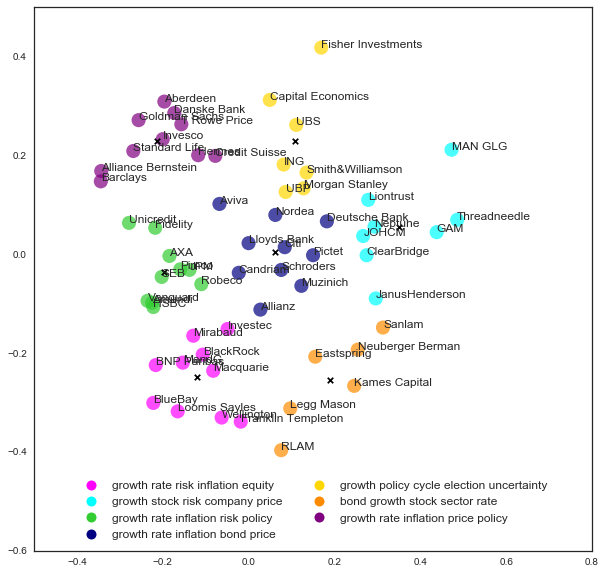

In [167]:
# visualise results

fig = plt.figure(figsize=(10,10))

sns.set_style("white")
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.xlim(-0.5,0.8)
plt.ylim(-0.6,0.5)
plt.rcParams.update({'font.size': 12})
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)

ax1.scatter(red_df['X'], red_df['Y'], c=red_df['Colour'], marker='o', s=200,
            edgecolors='none', alpha=0.7,label='')
ax2.scatter(clu['Centroid_x'], clu['Centroid_y'], s=30, c='k', marker="x", label=clu['Words'])

import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
import matplotlib.lines as mlines

line0 = mlines.Line2D([], [], color='magenta', marker='o', markersize=10, linestyle='None',label='')
line1 = mlines.Line2D([], [], color='cyan', marker='o', markersize=10, linestyle='None',label='')
line2 = mlines.Line2D([], [], color='limegreen', marker='o', markersize=10, linestyle='None', label='')
line3 = mlines.Line2D([], [], color='navy', marker='o', markersize=10, linestyle='None', label='')
line4 = mlines.Line2D([], [], color='gold', marker='o', markersize=10, linestyle='None', label='')
line5 = mlines.Line2D([], [], color='darkorange', marker='o', markersize=10, linestyle='None', label='')
line6 = mlines.Line2D([], [], color='purple', marker='o', markersize=10, linestyle='None', label='')

ax2.legend([line0, line1, line2, line3, line4, line5, line6],[c for c in clu['Words']],
         loc = 'lower center', ncol=2, labelspacing=0.5, fontsize=12)

for i in range(len(red_df)):
    ax1.text(red_df.ix[i]['X'], red_df.ix[i]['Y'], red_df.ix[i]['Names'], size=12)  

# LDA topic modelling

magenta: growth  rate  risk  inflation  equity  bond  policy  asset  credit  yield

cyan: growth  rate  price  risk  bond  equity  sector  term  yield  policy

limegreen: growth  rate  inflation  price  policy  risk  q  term  wage  interest


In [168]:
# prepare clusters for Latent Dirichlet Allocation

def prep_cluster(text):
    t = [[i for i in ls.split()] for ls in text[0]]
    return t


In [169]:
# edit number of clusters

cl_0 = prep_cluster(cluster_0)
cl_1 = prep_cluster(cluster_1)
cl_2 = prep_cluster(cluster_2)
cl_3 = prep_cluster(cluster_3)
cl_4 = prep_cluster(cluster_4)
cl_5 = prep_cluster(cluster_5)
cl_6 = prep_cluster(cluster_6)

In [170]:
# edit number of clusters

clusters = [cl_0, cl_1, cl_2, cl_3, cl_4, cl_5, cl_6]

In [171]:
# use Latent Dirichlet Allocation for topic modelling

from gensim import corpora, models 

def lda_model(words):
    for c in clusters:
        dictionary = corpora.Dictionary(c)
        corpus_lda = [dictionary.doc2bow(text) for text in c] 
        lda = models.LdaModel(corpus_lda, num_topics=1,  
                                id2word=dictionary) 
        topics_matrix = lda.show_topics(formatted=True, num_words=10)
        raw = raw_text(topics_matrix)
        stuff = ["'", "+", '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '*', '.', '"', ',']
        chars = [''.join([char for char in l if char not in stuff]) for l in raw]
        topics = pd.DataFrame(chars, columns = ['Words'])
        for w in topics.Words:
            print(w)
    return 

In [172]:
lda_model(clusters)


 growth  rate  risk  inflation  equity  policy  bond  credit  yield  asset
 growth  stock  risk  price  company  rate  race  term  value  valuation
 growth  rate  inflation  risk  policy  yield  equity  asset  term  return
 growth  rate  inflation  bond  price  policy  risk  yield  interest  equity
 growth  policy  cycle  uncertainty  election  gdp  liquidity  rate  recovery  sheet
 bond  growth  stock  sector  rate  equity  volatility  yield  inflation  risk
 growth  rate  inflation  price  policy  risk  term  wage  tax  forecast


In [173]:
red_df.groupby(by='Colour', axis=0).mean()

,X,Y,Cluster
Colour,,,
cyan,0.350673,0.054696,1
darkorange,0.190039,-0.253819,5
gold,0.108410,0.228439,4
limegreen,-0.197427,-0.035350,2
magenta,-0.120720,-0.248570,0
navy,0.061256,0.003833,3
purple,-0.213558,0.228715,6


# LDA topic modelling

magenta: growth  rate  risk  inflation  equity  bond  policy  asset  credit  yield

cyan: growth  rate  price  risk  bond  equity  sector  term  yield  policy

limegreen: growth  rate  inflation  price  policy  risk  q  term  wage  interest


In [174]:
# generate ngrams

from nltk.util import ngrams
from collections import Counter

In [175]:
def ngram_counter(cluster):
    counts = Counter()
    for sent in cluster:
        counts.update(" ".join(n) for n in nltk.ngrams(sent, 2))
    #print(counts.most_common(3))
    #print(' ')
    return counts.most_common(3)

In [176]:
grams = []
for c in clusters:
    
    #print('Cluster',  clusters.index(c), ':')
    g = ngram_counter(c)
    grams.append(g)


In [177]:
grams

[[('interest rate', 89), ('government bond', 32), ('balance sheet', 28)],
 [('interest rate', 19), ('risk premium', 9), ('discount rate', 9)],
 [('interest rate', 103), ('balance sheet', 56), ('rate hike', 43)],
 [('interest rate', 44), ('oil price', 15), ('bond yield', 14)],
 [('policy uncertainty', 11), ('balance sheet', 11), ('business cycle', 9)],
 [('interest rate', 20), ('government bond', 8), ('bond yield', 8)],
 [('interest rate', 61), ('wage growth', 36), ('rate hike', 31)]]

In [178]:
top_grams = []

for g in grams:
    for m in g:
        top_grams.append(m[0])
    

In [179]:
top_grams

['interest rate',
 'government bond',
 'balance sheet',
 'interest rate',
 'risk premium',
 'discount rate',
 'interest rate',
 'balance sheet',
 'rate hike',
 'interest rate',
 'oil price',
 'bond yield',
 'policy uncertainty',
 'balance sheet',
 'business cycle',
 'interest rate',
 'government bond',
 'bond yield',
 'interest rate',
 'wage growth',
 'rate hike']

In [180]:
# edit number of clusters

clu['top_grams'] = [top_grams[0:3], top_grams[3:6], top_grams[6:9], top_grams[9:12], top_grams[12:15],
                   top_grams[15:18], top_grams[18:21]]

In [181]:
clu

,Words,Cluster,Centroid_x,Centroid_y,top_grams
0,growth rate risk inflation equity,0,[-0.120720189355],[-0.24857047292],"[interest rate, government bond, balance sheet]"
1,growth stock risk company price,1,[0.350672980837],[0.0546960508492],"[interest rate, risk premium, discount rate]"
2,growth rate inflation risk policy,2,[-0.197427309153],[-0.0353500908737],"[interest rate, balance sheet, rate hike]"
3,growth rate inflation bond price,3,[0.0612561316375],[0.00383278889411],"[interest rate, oil price, bond yield]"
4,growth policy cycle election uncertainty,4,[0.108410479476],[0.228439288427],"[policy uncertainty, balance sheet, business c..."
5,bond growth stock sector rate,5,[0.190039466737],[-0.25381866173],"[interest rate, government bond, bond yield]"
6,growth rate inflation price policy,6,[-0.213558033474],[0.228714629359],"[interest rate, wage growth, rate hike]"


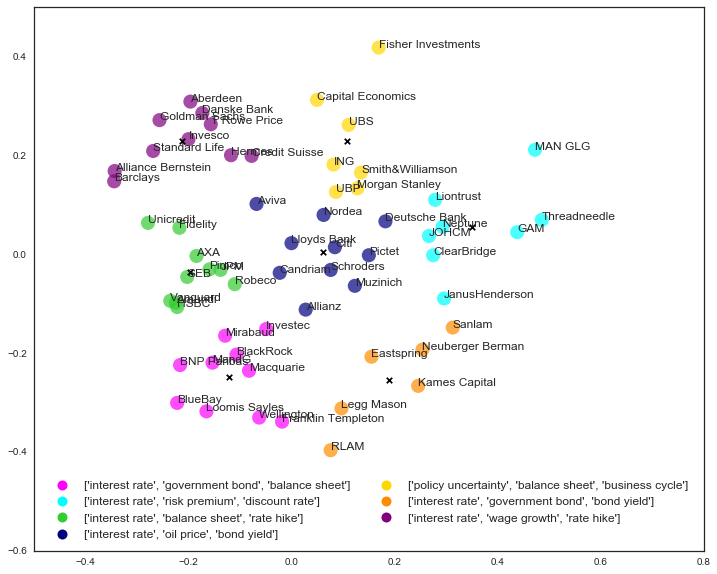

In [182]:
# visualise results with n_grams

fig = plt.figure(figsize=(12,10))

sns.set_style("white")
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.xlim(-0.5,0.8)
plt.ylim(-0.6,0.5)
plt.rcParams.update({'font.size': 12})
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)

ax1.scatter(red_df['X'], red_df['Y'], c=red_df['Colour'], marker='o', s=200,
            edgecolors='none', alpha=0.7,label='')
ax2.scatter(clu['Centroid_x'], clu['Centroid_y'], s=30, c='k', marker="x", label=clu['top_grams'])

import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
import matplotlib.lines as mlines

line0 = mlines.Line2D([], [], color='magenta', marker='o', markersize=10, linestyle='None',label='')
line1 = mlines.Line2D([], [], color='cyan', marker='o', markersize=10, linestyle='None',label='')
line2 = mlines.Line2D([], [], color='limegreen', marker='o', markersize=10, linestyle='None', label='')
line3 = mlines.Line2D([], [], color='navy', marker='o', markersize=10, linestyle='None', label='')
line4 = mlines.Line2D([], [], color='gold', marker='o', markersize=10, linestyle='None', label='')
line5 = mlines.Line2D([], [], color='darkorange', marker='o', markersize=10, linestyle='None', label='')
line6 = mlines.Line2D([], [], color='purple', marker='o', markersize=10, linestyle='None', label='')

ax2.legend([line0, line1, line2, line3, line4, line5, line6],[c for c in clu['top_grams']],
         loc = 'lower center', ncol=2, labelspacing=0.5, fontsize=12)

for i in range(len(red_df)):
    ax1.text(red_df.ix[i]['X'], red_df.ix[i]['Y'], red_df.ix[i]['Names'], size=12)  